# GD1

In this notebook we replace the results in ` Alvey et al. 2024` on the GD1 stream. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# from autocvd import autocvd
# autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})
plt.style.use('default')



## Setting up the simulation parameters and configurations

In [4]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 5000, 
                          return_snapshots = True, 
                          num_snapshots =1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


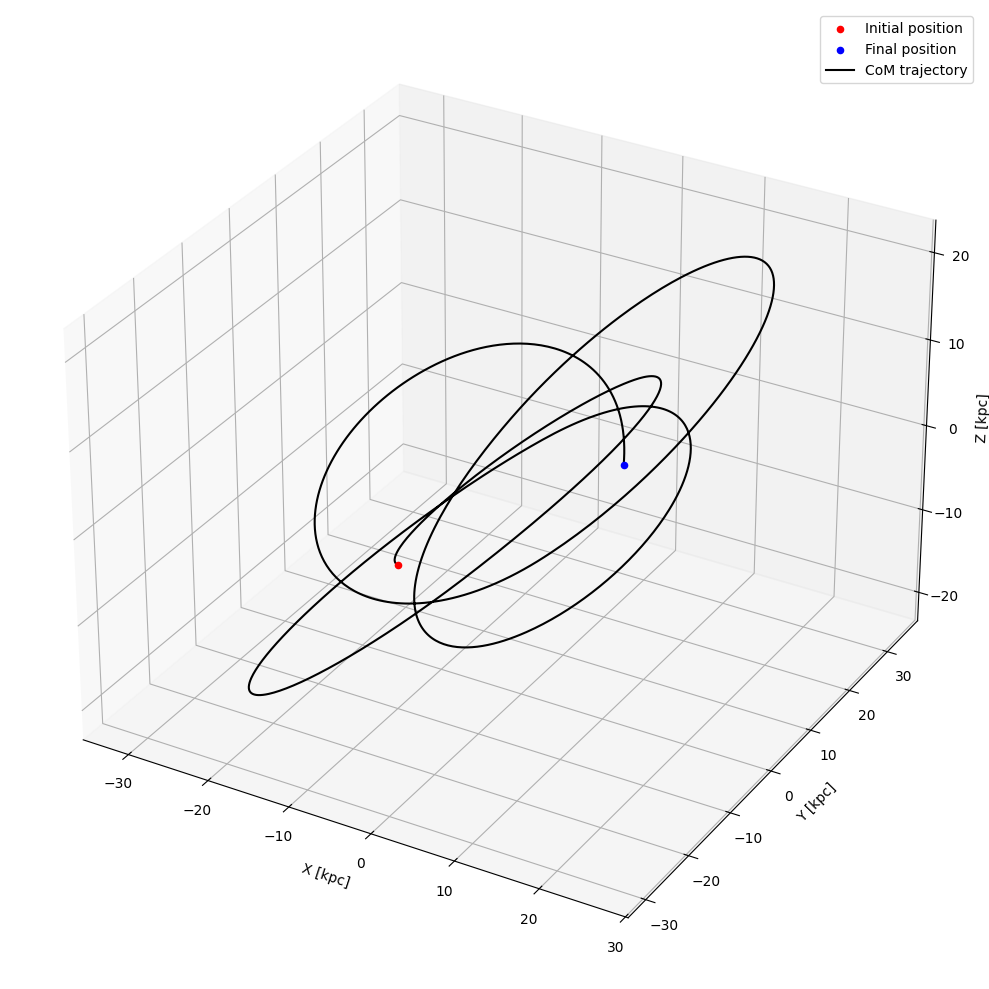

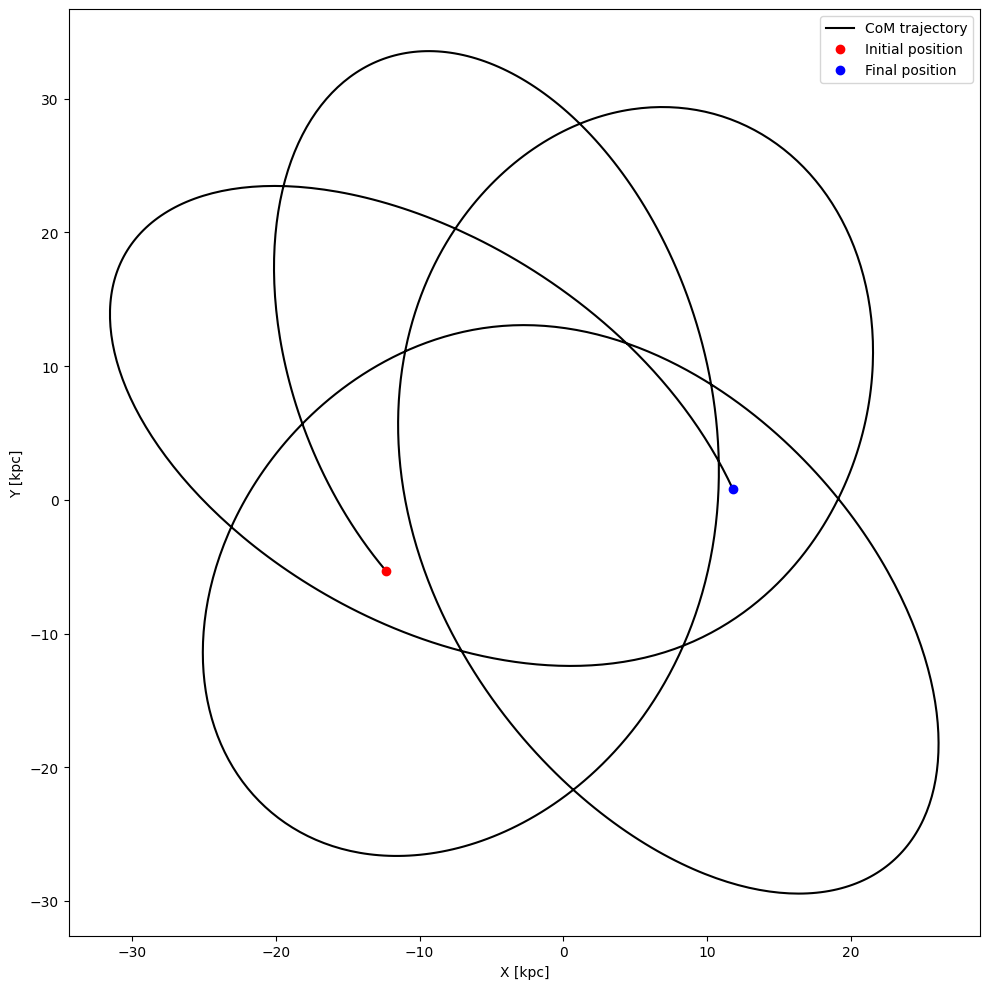

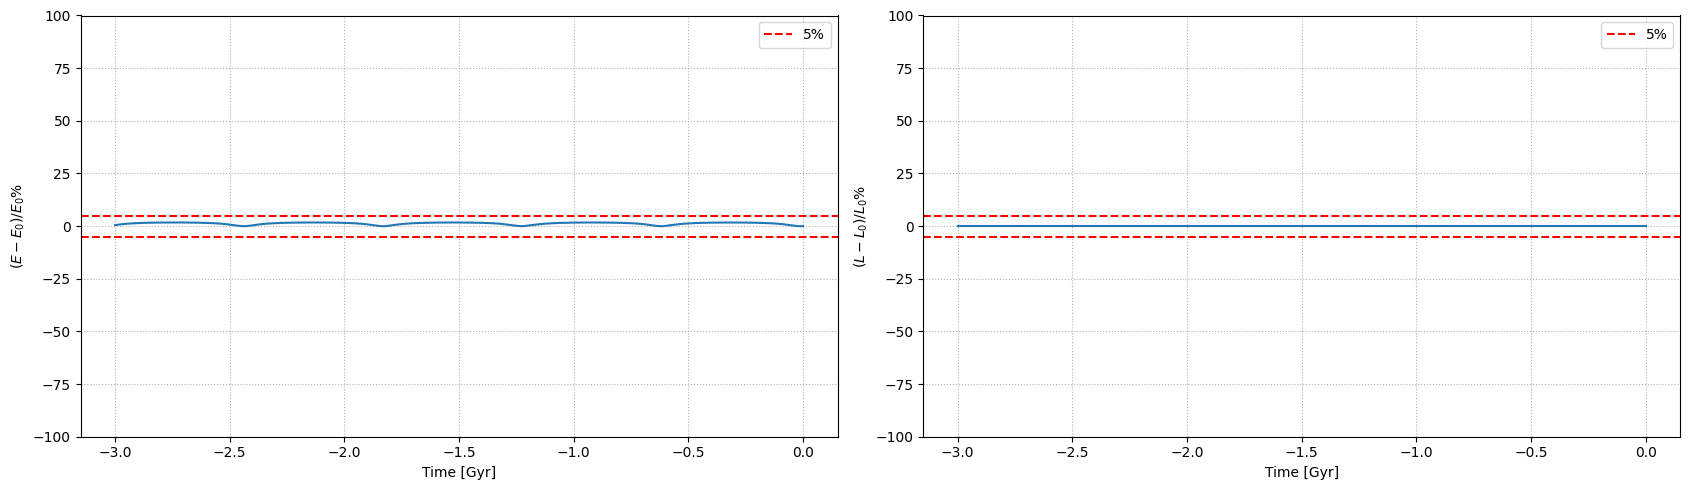

In [5]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final) # state is a (N_particles x 2 x 3)

#evolution in time
snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)

#we can plot the snapshots of simulations, the snapshot are NameTuple with states=(N_snapshots x N_particles x 2 x 3) array
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

#check conservation of energy and angular momentum
energy_angular_momentum_plot(snapshots_com, code_units,)

## Dwarf Galaxy position and velocity

In [6]:
# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

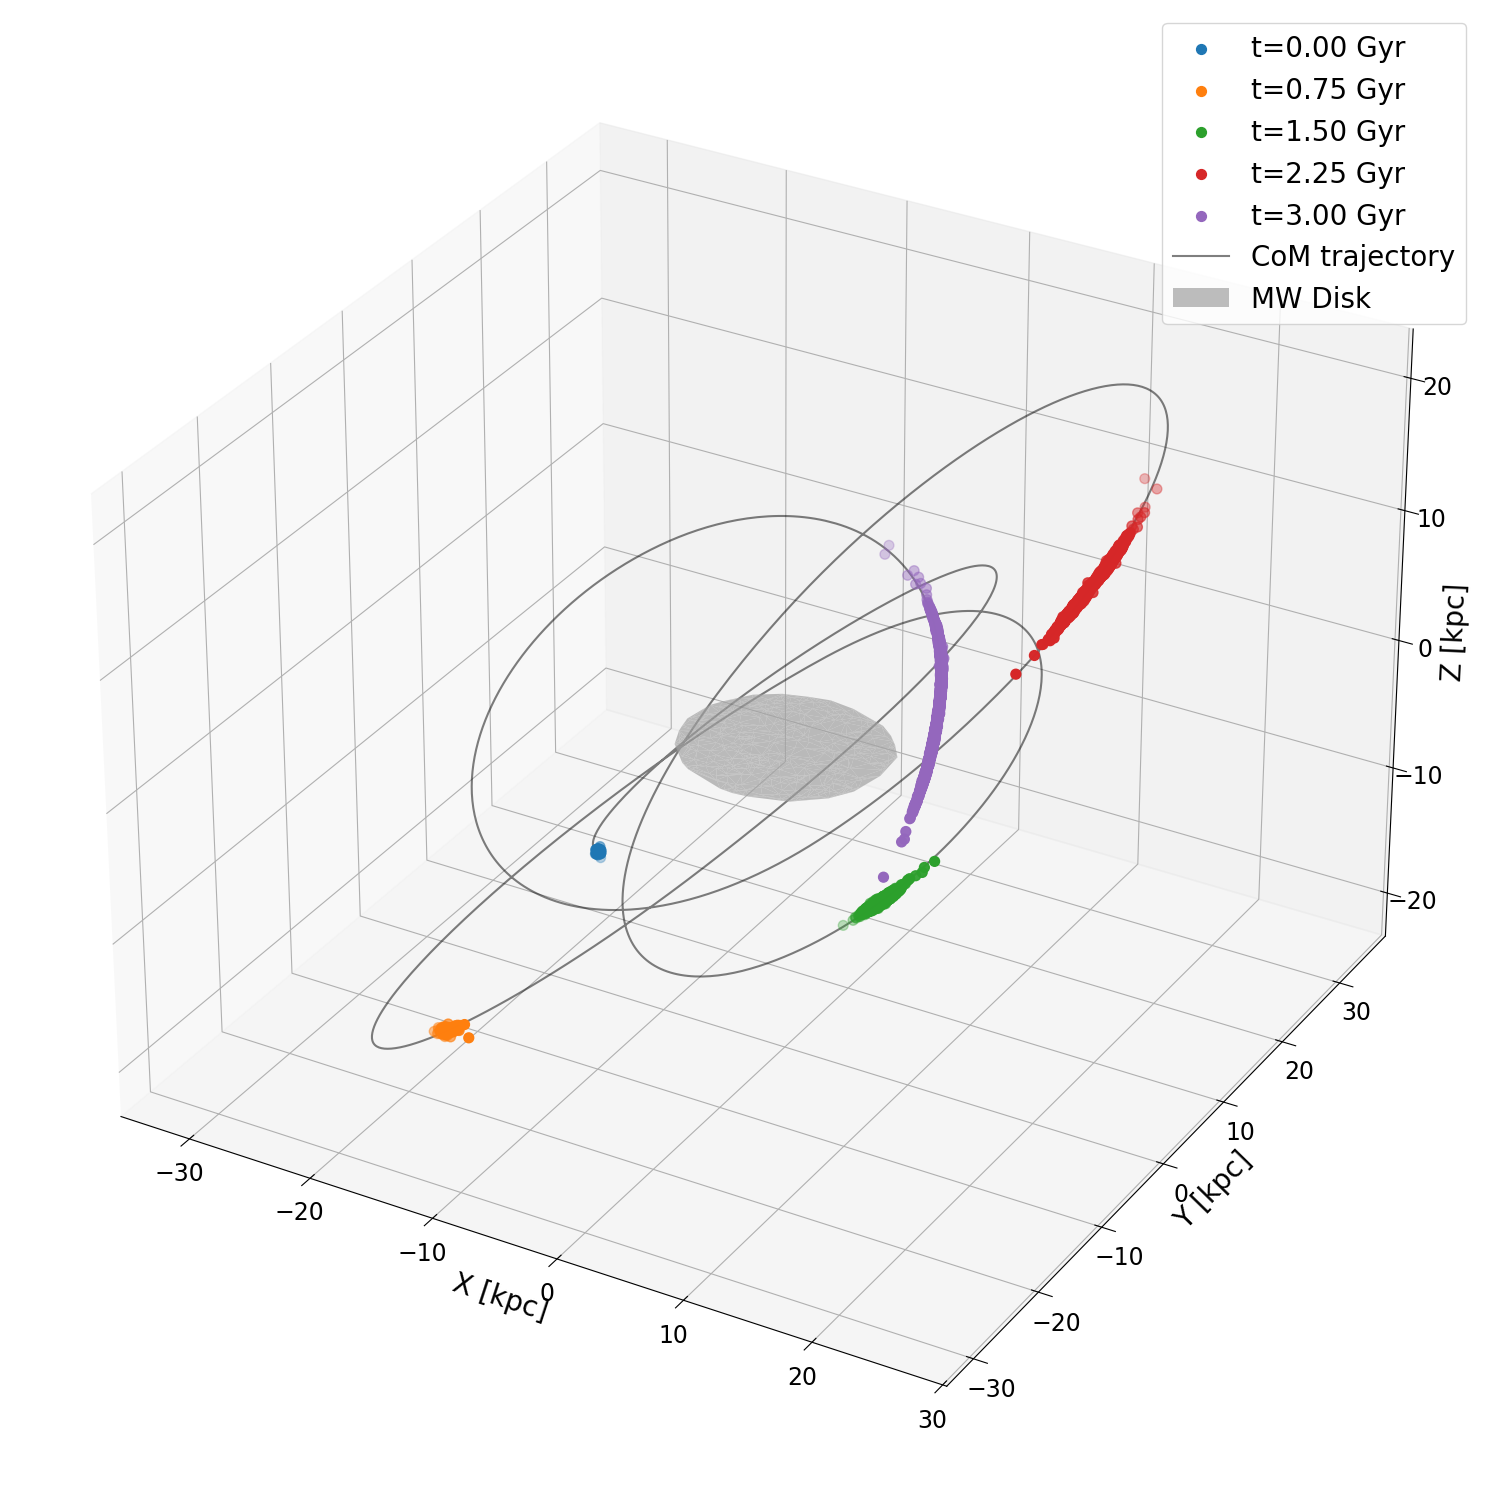

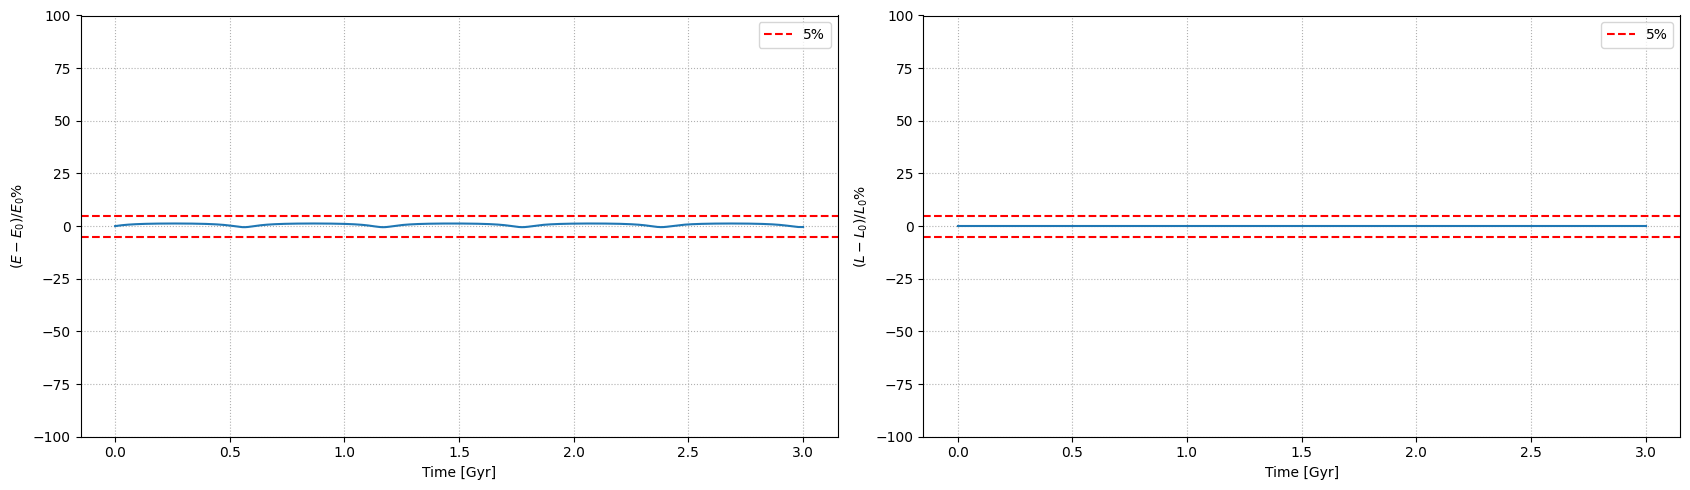

In [7]:
plt.style.use('default')

# Create a circular ring (solid line)
radius = 8 #kpc
z_disk = 0
theta = np.linspace(0, 2*np.pi, 500)
x_ring = radius * np.cos(theta)
y_ring = radius * np.sin(theta)
z_ring = np.full_like(theta, z_disk)

fig = plt.figure(figsize=(15, 15), tight_layout=True,)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), 
               label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}",
               s=50)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', alpha=0.5, label='CoM trajectory')
# ax.scatter(0, 0, 0, c='k', s=100, )

# Ring (Milky Way disk)
# ax.plot(x_ring, y_ring, z_ring, color="royalblue", linewidth=3, label="MW Disk")

r = 8
n = 500

# Random polar points inside the disk
theta = np.random.uniform(0, 2*np.pi, n)
rho = r * np.sqrt(np.random.uniform(0, 1, n))  # ensures uniform density
x = rho * np.cos(theta)
y = rho * np.sin(theta)
z = np.zeros_like(x)

# Triangular surface
ax.plot_trisurf(x, y, z, color="lightgray", alpha=0.7, linewidth=0, label="MW Disk")

ax.set_xlabel('X [kpc]', fontsize=20)
ax.set_ylabel('Y [kpc]', fontsize=20)
ax.set_zlabel('Z [kpc]', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=17)  # 


# Remove the grid
# ax.grid(False)

energy_angular_momentum_plot(snapshots, code_units,)


Text(0, 0.5, 'Y [kpc]')

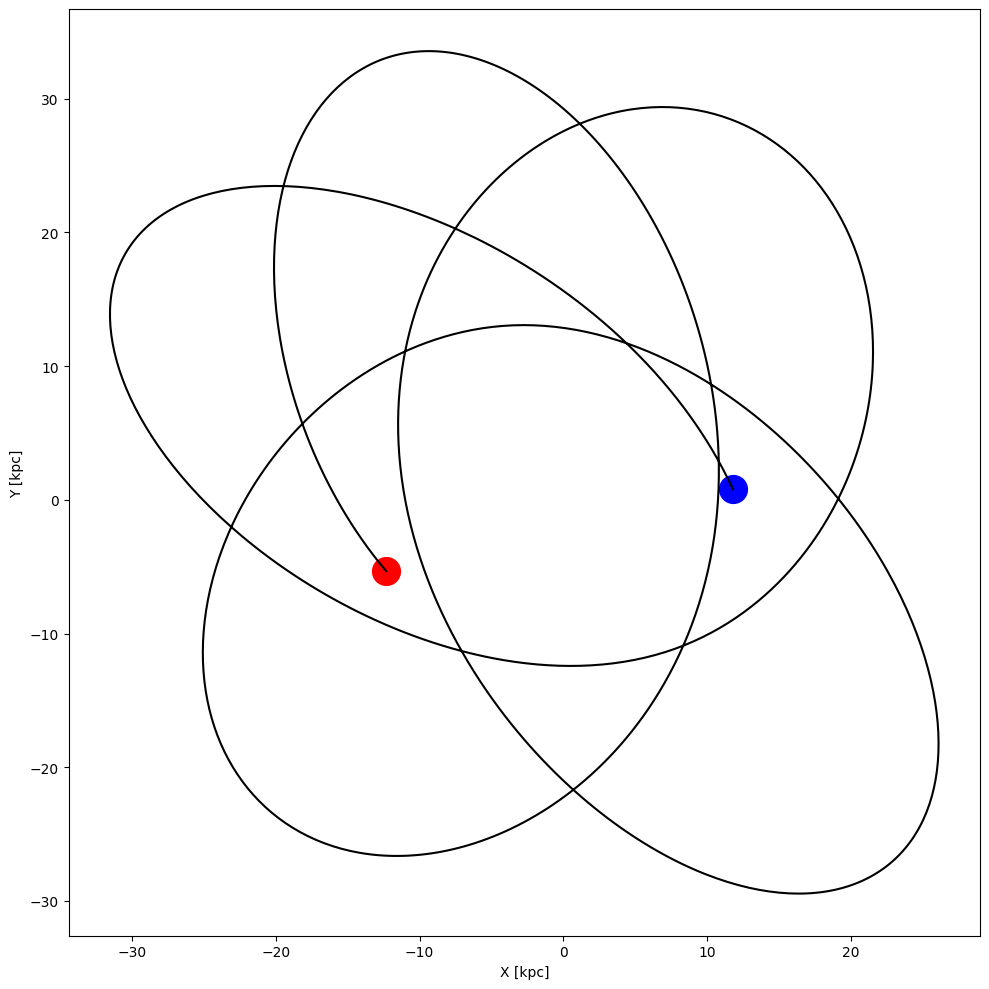

In [52]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), c='r', s=400, label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), c='b', s=400, label='Final position')
# ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
#     snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.legend()

In [63]:
snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc)
snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc)

Array(-5.3250513, dtype=float32)

(-5.5, -5.1)

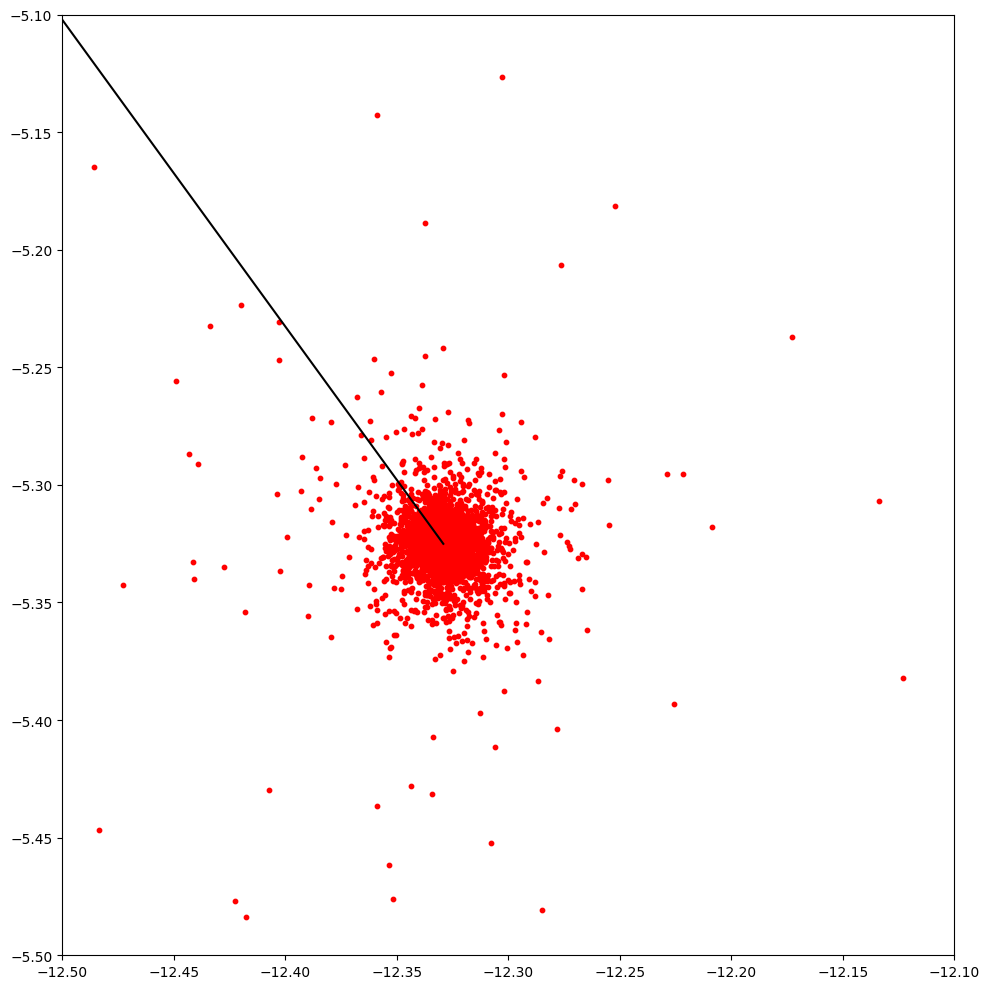

In [67]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), c='r', s=10, label='Initial position')
ax.scatter(snapshots.states[0, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[0, :, 0, 1]* code_units.code_length.to(u.kpc), s=10, c='r', label='Final positions of the stream')
ax.set_xlim(-12.5, -12.1,)
ax.set_ylim(-5.5, -5.1)

In [ ]:
Given: 
CoM = snapshots_com.states[0]*conversion
observed_stream = snapshots.states[-1]*conversion
observed_stream = np.array(observed_stream)

CoM is a (1, 2, 3) array (1 particle, position and velocity, 3 coordinates)
observed_stream is a (N_particles, 2, 3) array (N_particles, position and velocity, 3 coordinates)
can you calculate a rotation of the observed stream around the CoM such that the rotation is of 15 degrees

SyntaxError: invalid syntax (4077156630.py, line 1)

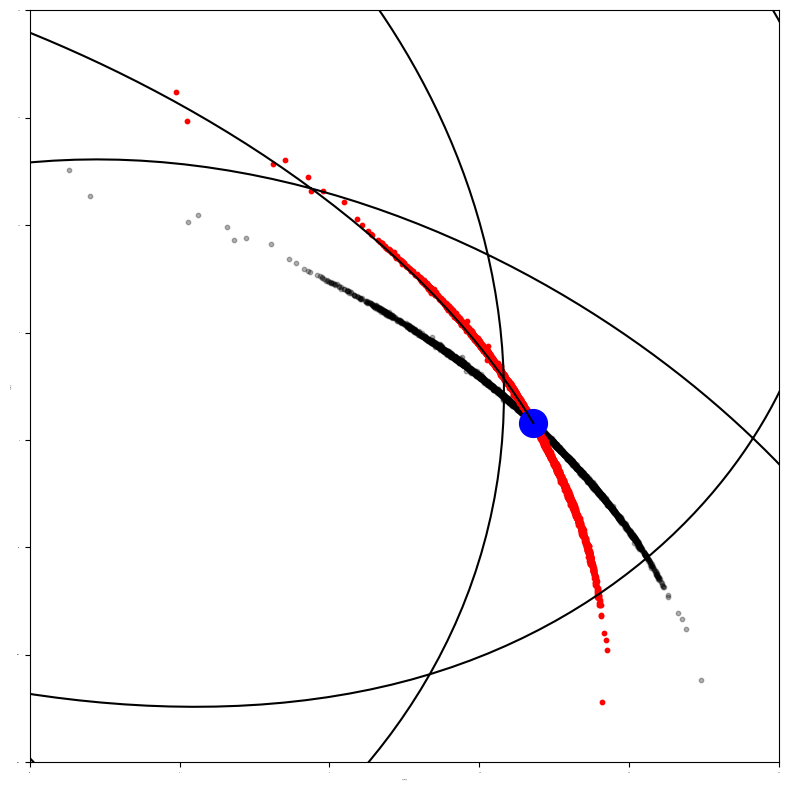

In [86]:
conversion = code_units.code_length.to(u.kpc)
CoM = snapshots_com.states[0]*conversion
simulation_stream = snapshots.states[-1]*conversion
simulation_stream = np.array(simulation_stream)

import numpy as np

def rotation_matrix(axis, angle_deg):
    """Axis can be 'x'|'y'|'z' or a 3D vector; angle in degrees."""
    th = np.deg2rad(angle_deg)
    if isinstance(axis, str):
        if axis.lower() == 'x':
            R = np.array([[1, 0, 0],
                          [0, np.cos(th), -np.sin(th)],
                          [0, np.sin(th),  np.cos(th)]])
        elif axis.lower() == 'y':
            R = np.array([[ np.cos(th), 0, np.sin(th)],
                          [0,           1, 0],
                          [-np.sin(th), 0, np.cos(th)]])
        elif axis.lower() == 'z':
            R = np.array([[np.cos(th), -np.sin(th), 0],
                          [np.sin(th),  np.cos(th), 0],
                          [0,           0,          1]])
        else:
            raise ValueError("axis must be 'x', 'y', or 'z' when a string")
        return R
    # Arbitrary axis (Rodrigues' formula)
    a = np.asarray(axis, dtype=float)
    a = a / np.linalg.norm(a)
    K = np.array([[0,     -a[2],  a[1]],
                  [a[2],   0,    -a[0]],
                  [-a[1],  a[0],  0   ]])
    I = np.eye(3)
    R = I + np.sin(th)*K + (1-np.cos(th))*(K @ K)
    return R

def rotate_stream_about_com(simulation_stream, CoM, angle_deg=15.0, axis='z'):
    """
    simulation_stream: (N, 2, 3)  [0: pos, 1: vel]
    CoM:             (1, 2, 3)  [0: pos, 1: vel]
    Rotates positions and velocities by angle around CoM.
    """
    R = rotation_matrix(axis, angle_deg)

    pos = simulation_stream[:, 0, :]           # (N,3)
    vel = simulation_stream[:, 1, :]           # (N,3)
    com_pos = CoM[0, 0, :]                   # (3,)
    com_vel = CoM[0, 1, :]                   # (3,)

    # Shift to CoM frame
    pos_rel = pos - com_pos
    vel_rel = vel - com_vel

    # Rotate (note: right-multiplying by R^T since rows are vectors)
    pos_rot = pos_rel @ R.T + com_pos
    vel_rot = vel_rel @ R.T + com_vel

    out = simulation_stream.copy()
    out[:, 0, :] = pos_rot
    out[:, 1, :] = vel_rot
    return out

# --- usage ---
observed_stream = rotate_stream_about_com(simulation_stream, CoM, angle_deg=15.0, axis='z')
# simulation_stream = simulation_stream[np.linalg.norm(simulation_stream.T - CoM.T) < 100]



fig = plt.figure(figsize=(8, 8), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.scatter(observed_stream[:, 0, 0], 
           observed_stream[:, 0, 1], s=10, c='k', alpha=0.3, label='Observed stream')
ax.scatter(simulation_stream[:, 0, 0], 
           simulation_stream[:, 0, 1], s=10, c='r', label='Simulated stream')
ax.scatter(CoM[0, 0, 0], 
        CoM[0, 0, 1], c='b', s=400, label='CoM final position')
ax.set_xlabel("X [kpc]", fontsize=0)
ax.set_ylabel("Y [kpc]", fontsize=0)
ax.set_xlim(-5, 20,)
ax.set_ylim(-15, 20)
# ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=0)  # 

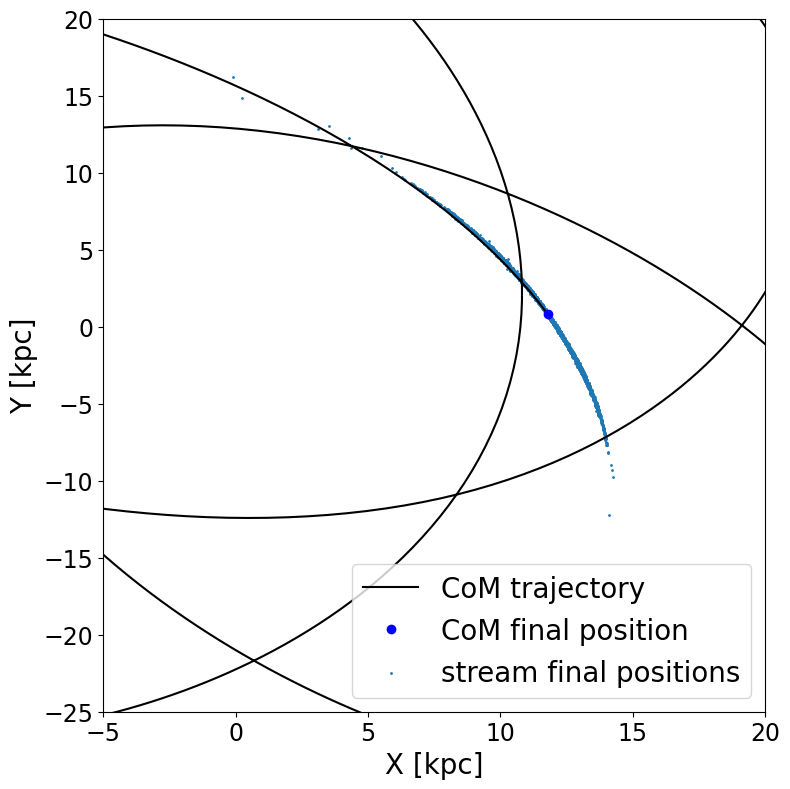

In [ ]:
fig = plt.figure(figsize=(8, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]*conversion, 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='CoM final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=1, label='Simulated Stream final positions')
ax.set_xlabel("X [kpc]", fontsize=20)
ax.set_ylabel("Y [kpc]", fontsize=20)
ax.set_xlim(-5, 20,)
ax.set_ylim(-25, 20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=17)  # 


In [9]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

## Projection on the GD1 plane 

(-250.0, 250.0)

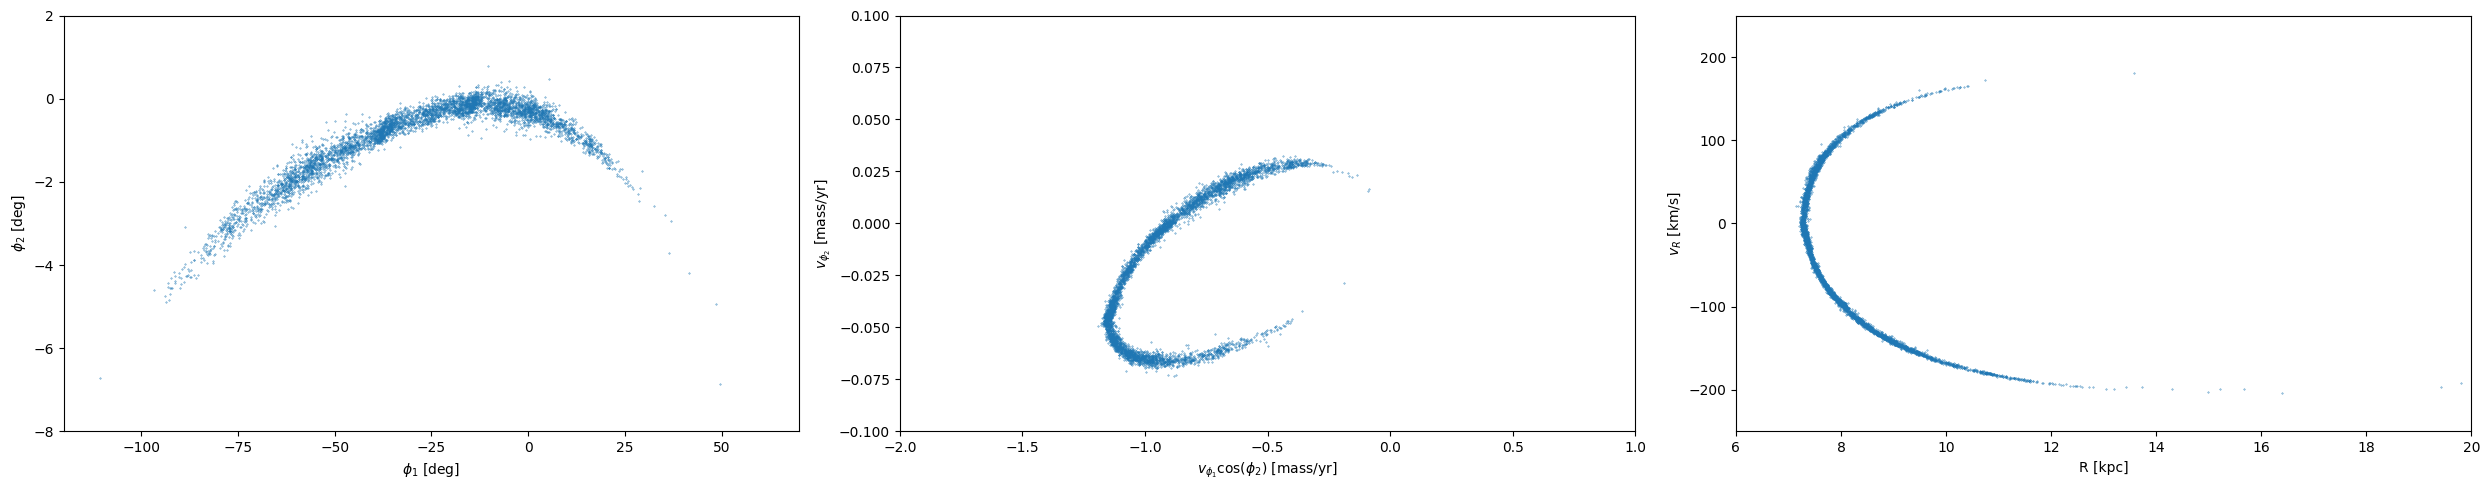

In [10]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_1800442/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_1800442/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_1800442/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


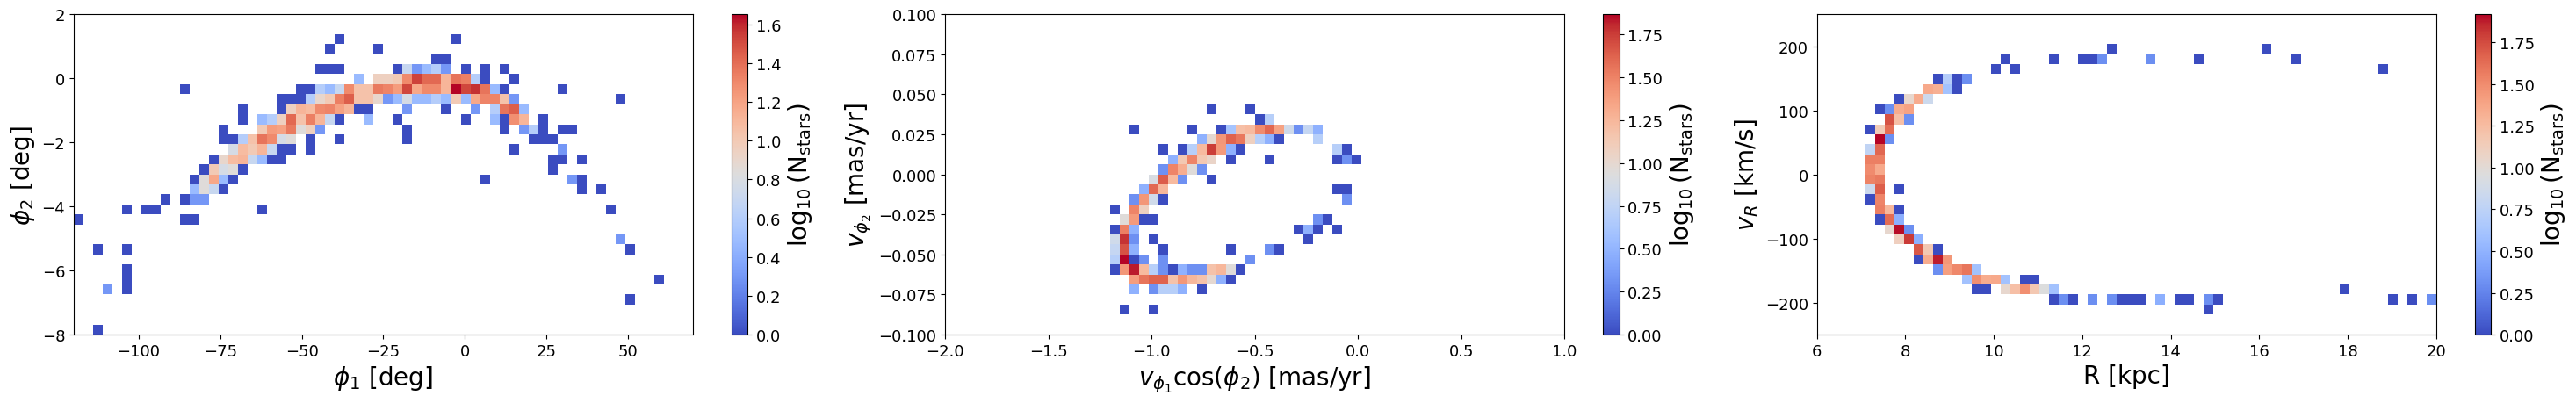

In [ ]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

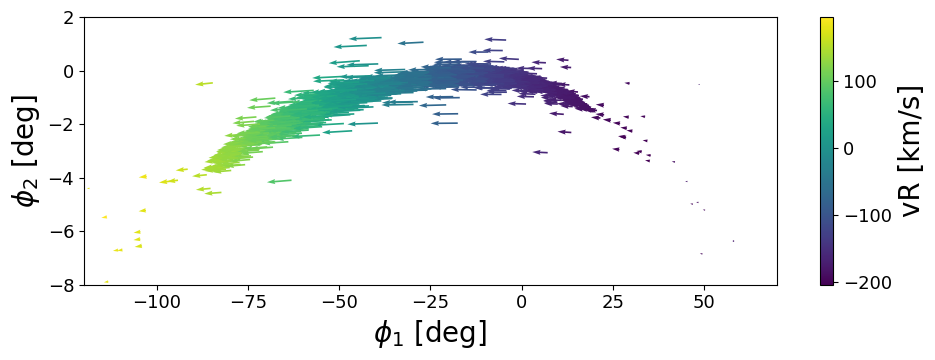

In [ ]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)